In [1]:
from unsloth import FastLanguageModel, is_bfloat16_supported
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 04-24 19:55:34 [__init__.py:239] Automatically detected platform cuda.


In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 1024 # Can increase for longer reasoning traces
lora_rank = 32 # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen2.5-3B-Instruct",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = False, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.6, # Reduce if out of memory
)

model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ], # Remove QKVO if out of memory
    lora_alpha = lora_rank,
    use_gradient_checkpointing = "unsloth", # Enable long context finetuning
    random_state = 3407,
)

==((====))==  Unsloth 2025.3.19: Fast Qwen2 patching. Transformers: 4.51.3. vLLM: 0.8.4.
   \\   /|    NVIDIA GeForce RTX 4070 Laptop GPU. Num GPUs = 1. Max memory: 7.747 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.3.19 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


In [16]:
import re
import pandas as pd
from datasets import load_dataset, Dataset

# Load and prep dataset
SYSTEM_PROMPT = """
Respond in the following format and put the final answer as the last number in the answer:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""

XML_COT_FORMAT = """\
<reasoning>
{reasoning}
</reasoning>
<answer>
{answer}
</answer>
"""

def extract_xml_answer(text: str) -> str:
    answer = text.split("<answer>")[-1]
    answer = answer.split("</answer>")[0]
    return answer.strip()

def extract_hash_answer(text: str) -> str | None:
    if "####" not in text:
        return None
    return text.split("####")[1].strip()

def extract_answer_from_output(completion):
    ANS_RE = re.compile(r"\b(\-?[0-9]+(?:[.,][0-9]+)?)\b")  # match full numeric tokens only
    matches = list(re.finditer(ANS_RE, completion))
    
    if not matches:
        return "-1"
    
    # Prefer the last numeric token, which avoids catching punctuation
    return matches[-1].group(1).replace(",", "").strip()
    
def check_answer(output_text, answer):
    # Extract the answer from the output text
    extracted_answer = extract_answer_from_output(extract_xml_answer(output_text))
    # print(f"Extracted answer: {extracted_answer}")
    # Compare with the expected answer
    return extracted_answer == answer


# uncomment middle messages for 1-shot prompting
def get_gsm8k_french_questions():
    data = pd.read_csv("gsm8k-french2-translated.csv")
    # print(data['french_question'])
    data = data.apply(lambda x: { # type: ignore
        'prompt': [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['french_question']}
        ],
        'answer': extract_hash_answer(x['answer'])
    }, axis=1) # type: ignore
    return data # type: ignore

def get_gsm8k_questions():
    data = pd.read_csv("gsm8k-french2-translated.csv")
    # print(data['french_question'])
    data = data.apply(lambda x: { # type: ignore
        'prompt': [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['question']}
        ],
        'answer': extract_hash_answer(x['answer'])
    }, axis=1) # type: ignore
    return data # type: ignore

dataset = get_gsm8k_questions()

# Reward functions
def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    q = prompts[0][-1]['content']
    extracted_responses = [extract_answer_from_output(r) for r in responses]
    print('-'*20, f"Question:\n{q}", f"\nAnswer:\n{answer[0]}", f"\nResponse:\n{responses[0]}", f"\nExtracted:\n{extracted_responses[0]}")
    return [2.0 if r == a else 0.0 for r, a in zip(extracted_responses, answer)]

def int_reward_func(completions, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_answer_from_output(r) for r in responses]
    return [0.5 if r.isdigit() else 0.0 for r in extracted_responses]

def strict_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"^<reasoning>\n.*?\n</reasoning>\n<answer>\n.*?\n</answer>\n$"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

def soft_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

def count_xml(text) -> float:
    count = 0.0
    if text.count("<reasoning>\n") == 1:
        count += 0.125
    if text.count("\n</reasoning>\n") == 1:
        count += 0.125
    if text.count("\n<answer>\n") == 1:
        count += 0.125
        count -= len(text.split("\n</answer>\n")[-1])*0.001
    if text.count("\n</answer>") == 1:
        count += 0.125
        count -= (len(text.split("\n</answer>")[-1]) - 1)*0.001
    return count

def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    contents = [completion[0]["content"] for completion in completions]
    return [count_xml(c) for c in contents]

In [17]:
from torch.utils.data import DataLoader

BATCH_SIZE = 8  # Tune based on your VRAM

def collate_fn(batch):
    tokenizer.padding_side = "right"
    prompts = [tokenizer.apply_chat_template(item['prompt'], tokenize=False, add_generation_prompt=True) for item in batch]
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(model.device)
    return inputs, batch

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)


In [18]:
total, correct = 0, 0

with torch.inference_mode():
    model.eval()
    for inputs, batch in dataloader:
        output_ids = model.generate(
            inputs['input_ids'],
            do_sample=False,
            max_new_tokens=512,
            output_attentions=False,
            output_hidden_states=False,
        )
        outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        # print(outputs[0])
        for output_text, item in zip(outputs, batch):
            if check_answer(output_text, item['answer']):
                correct += 1
            # else:
            #     print(output_text)
            #     extracted_answer = extract_answer_from_output(extract_xml_answer(output_text))
            #     print(extracted_answer, item['answer'])
            total += 1

        print(correct, total)
print(f"Accuracy: {correct / total * 100:.2f}%")

8 8
15 16
20 24
26 32
33 40
40 48
48 56
55 64
62 72
70 80
76 88
83 96
89 104
95 112
103 120
111 128
117 136
123 144
131 152
137 160
142 168
148 176
154 184
161 192
169 200
177 208
183 216
189 224
192 232
196 240
204 248
210 256
216 264
223 272
231 280
235 288
243 296
250 304
257 312
264 320
269 328
274 336
280 344
286 352
293 360
299 368
307 376
315 384
322 392
327 400
332 408
338 416
346 424
352 432
360 440
368 448
375 456
381 464
388 472
394 480
399 488
407 496
412 504
417 512
424 520
430 528
438 536
445 544
453 552
461 560
468 568
475 576
483 584
491 592
499 600
506 608
512 616
519 624
526 632
532 640
537 648
543 656
550 664
556 672
562 680
569 688
576 696
583 704
589 712
597 720
605 728
613 736
620 744
627 752
633 760
639 768
647 776
654 784
661 792
668 800
676 808
683 816
690 824
697 832
703 840
709 848
716 856
721 864
725 872
732 880
739 888
745 896
751 904
757 912
763 920
768 928
776 936
784 944
791 952
798 960
805 968
811 975
Accuracy: 83.18%


In [64]:
from zlib_ng import zlib_ng

def perplexity(model, tokenizer, input):
    prompt = tokenizer.apply_chat_template(input, tokenize=False, add_generation_prompt=True)
    tokenized_input = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model(**tokenized_input, labels=tokenized_input["input_ids"])
        loss = outputs.loss
        perplexity = torch.exp(loss)
    return perplexity.item()

def zlib_entropy(input):
    text_bytes = input.encode('utf-8')
    compressed_data = zlib_ng.compress(text_bytes)
    entropy_bits = len(compressed_data)
    return entropy_bits

def zlib_perplexity_ratio(model, tokenizer, input):
    perplexity_value = perplexity(model, tokenizer, input)
    entropy_value = zlib_entropy(input[0]['content'] + "\n" + input[1]['content'])
    return entropy_value, perplexity_value

In [66]:
perplexity_values = []
entropy_values = []
for row in dataset:
    input_text = row['prompt']
    entropy, perp = zlib_perplexity_ratio(model, tokenizer, input_text)
    perplexity_values.append(perp)
    entropy_values.append(entropy)
    # entropy, perplexity_value = zlib_perplexity_ratio(model, tokenizer, input_text)
    # print(f"Input: {input_text}")
    # print(f"Entropy: {entropy}, Perplexity: {perplexity_value}")
print(f"Average Entropy: {sum(entropy_values) / len(entropy_values)}")
print(f"Average Perplexity: {sum(perplexity_values) / len(perplexity_values)}")
print(f"Average Entropy/Perplexity Ratio: {sum(entropy_values) / sum(perplexity_values)}")


Average Entropy: 222.51282051282053
Average Perplexity: 31.117674160492726
Average Entropy/Perplexity Ratio: 7.150689327395964


[]

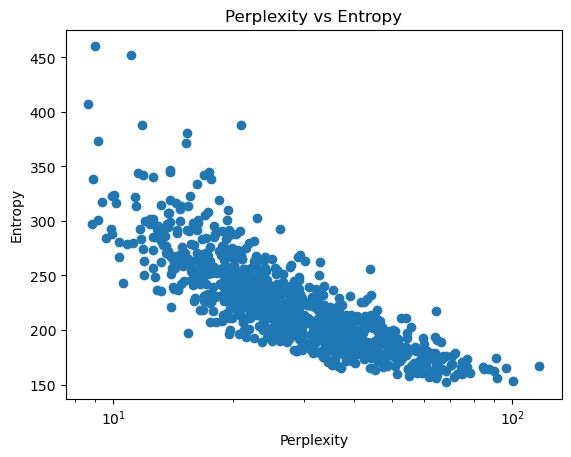

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(perplexity_values, entropy_values)
plt.xlabel('Perplexity')
plt.ylabel('Entropy')
plt.title('Perplexity vs Entropy')
plt.xscale('log')
plt.plot()

In [70]:
dataset = get_gsm8k_french_questions()
perplexity_values = []
entropy_values = []
for row in dataset:
    input_text = row['prompt']
    entropy, perp = zlib_perplexity_ratio(model, tokenizer, input_text)
    perplexity_values.append(perp)
    entropy_values.append(entropy)
    # entropy, perplexity_value = zlib_perplexity_ratio(model, tokenizer, input_text)
    # print(f"Input: {input_text}")
    # print(f"Entropy: {entropy}, Perplexity: {perplexity_value}")
print(f"Average Entropy: {sum(entropy_values) / len(entropy_values)}")
print(f"Average Perplexity: {sum(perplexity_values) / len(perplexity_values)}")
print(f"Average Entropy/Perplexity Ratio: {sum(entropy_values) / sum(perplexity_values)}")


Average Entropy: 248.0676923076923
Average Perplexity: 46.49402050605187
Average Entropy/Perplexity Ratio: 5.335475177402709


[]

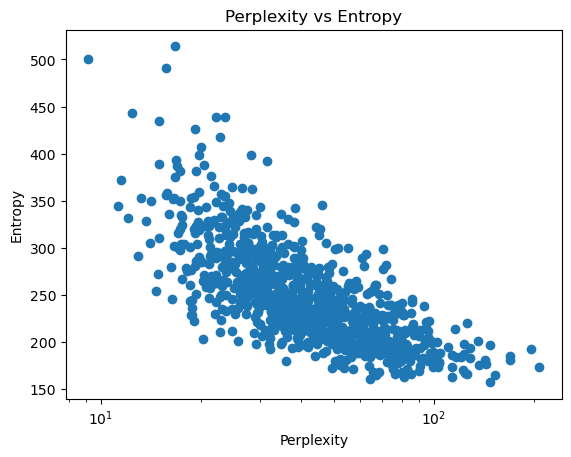

In [71]:
plt.scatter(perplexity_values, entropy_values)
plt.xlabel('Perplexity')
plt.ylabel('Entropy')
plt.title('Perplexity vs Entropy')
plt.xscale('log')
plt.plot()